In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import torch
import copy
# import torch_directml
# import lightning as L

In [2]:
torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [2]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [3]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,2))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(0),num_classes=2)
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(1),num_classes=2)
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete, axis=0)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


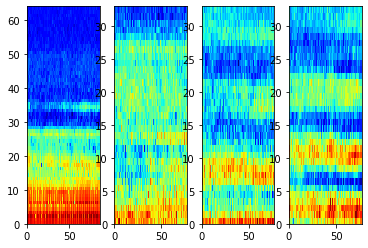

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### CNN1-model

In [51]:
class ALS_CNN1(nn.Module):
    def __init__(self):
        super(ALS_CNN1,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        input_chan = 2
        frames_in_segment = frames_in_segment - 1 # only for model with diff input
        self.layer1_filt = 6
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        # low/medium/high-frequency frequency span
        # low/medium/high-frequency time span
        lf1_height, lf1_width = 29,43
        lf2_height, lf2_width = 13,27
        lf3_height, lf3_width = 5,11

        mf_height,mf_width = 13,27
        mf2_height,mf2_width = 15,43

        hf_height,hf_width = 3,3     
        hf2_height,hf2_width = 7,7
        hf3_height,hf3_width = 13,27
        hf4_height,hf4_width = 15,31

        mf_h_stride, hf_h_stride = 2,1
        mf_w_stride, hf_w_stride = mf_width//2, hf_width//2
        
        lf1_h_stride, lf1_w_stride = lf1_height//2, lf1_width//2
        lf2_h_stride, lf2_w_stride = lf2_height//2, lf2_width//2
        lf3_h_stride, lf3_w_stride = lf3_height//2, lf3_width//2

        mf2_h_stride, mf2_w_stride = hf_height//2, mf2_width//2

        hf2_h_stride, hf2_w_stride = hf2_height//2, hf2_width//2
        hf3_h_stride, hf3_w_stride = hf3_height//2, hf3_width//2
        hf4_h_stride, hf4_w_stride = hf4_height//2, hf4_width//2

        self.batch_norm1 = nn.BatchNorm2d(input_chan)    # device='cuda'
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf1_height, lf1_width),padding='valid',stride=(lf1_h_stride, lf1_w_stride))
        self.conv_lf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf2_height, lf2_width),padding='valid',stride=(lf2_h_stride,lf2_w_stride))
        self.conv_lf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf3_height, lf3_width),padding='valid',stride=(lf3_h_stride,lf3_w_stride))

        self.conv_mf = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_mf2= torch.nn.Conv2d(input_chan,self.layer1_filt,(mf2_height, mf2_width),padding='valid',stride=(mf2_h_stride,mf2_w_stride))

        self.conv_hf = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))
        self.conv_hf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf2_height, hf2_width),padding='valid',stride=(hf2_h_stride,hf2_w_stride))
        self.conv_hf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf3_height, hf3_width),padding='valid',stride=(hf3_h_stride,hf3_w_stride))
        self.conv_hf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf4_height, hf4_width),padding='valid',stride=(hf4_h_stride,hf4_w_stride))

        max_pool_width = 1
        self.maxpool_lf1 = nn.MaxPool2d(((self.lf_num - lf1_height)//lf1_h_stride + 1,max_pool_width))        
        self.maxpool_lf2 = nn.MaxPool2d(((self.lf_num - lf2_height)//lf2_h_stride + 1,max_pool_width))
        self.maxpool_lf3 = nn.MaxPool2d(((self.lf_num - lf3_height)//lf3_h_stride + 1,max_pool_width))

        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1,max_pool_width))
        self.maxpool_mf2= nn.MaxPool2d(((self.mf_num - mf2_height)//mf2_h_stride + 1,max_pool_width))

        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1,max_pool_width))
        self.maxpool_hf2 = nn.MaxPool2d(((self.hf_num - hf2_height)//hf2_h_stride + 1,max_pool_width))
        self.maxpool_hf3 = nn.MaxPool2d(((self.hf_num - hf3_height)//hf3_h_stride + 1,max_pool_width))
        self.maxpool_hf4 = nn.MaxPool2d(((self.hf_num - hf4_height)//hf4_h_stride + 1,max_pool_width))

        self.drop1 = nn.Dropout(p=0.1)
        
        self.fc = nn.Linear(
                            self.layer1_filt*((1+(frames_in_segment-lf1_width)//lf1_w_stride)//max_pool_width ) + # *(1+(self.lf_num-lf_height)//lf_height)
                            self.layer1_filt*((1+(frames_in_segment-lf2_width)//lf2_w_stride)//max_pool_width ) +
                            self.layer1_filt*((1+(frames_in_segment-lf3_width)//lf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf_width)//mf_w_stride)//max_pool_width) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            self.layer1_filt*((1+(frames_in_segment-mf2_width)//mf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-hf_width)//hf_w_stride)//max_pool_width) + #*(1+(self.hf_num-hf_height)//hf_height)
                            self.layer1_filt*((1+(frames_in_segment-hf2_width)//hf2_w_stride)//max_pool_width) + 
                            self.layer1_filt*((1+(frames_in_segment-hf3_width)//hf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-hf4_width)//hf4_w_stride)//max_pool_width)
                            ,2)                               

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf1.weight)
        nn.init.xavier_uniform_(self.conv_lf2.weight)
        nn.init.xavier_uniform_(self.conv_lf3.weight)
        nn.init.xavier_uniform_(self.conv_mf.weight)
        nn.init.xavier_uniform_(self.conv_mf2.weight)
        nn.init.xavier_uniform_(self.conv_hf.weight)
        nn.init.xavier_uniform_(self.conv_hf2.weight)
        nn.init.xavier_uniform_(self.conv_hf3.weight)
        nn.init.xavier_uniform_(self.conv_hf4.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x): 
        
        # print('x size', x.shape)
        x_diff = x[:,:,:,1:] - x[:,:,:,0:-1]
        # print('x_diff', x_diff.shape)
        # print('x', x[:,:,:,1:].shape)
        out = torch.cat((x[:,:,:,1:],x_diff), dim=1)
        # print('x merge', out.shape)

        out = self.batch_norm1(out)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        out_lf2 = out1.detach()
        out_lf3 = out1.detach()

        out_mf2 = out2.detach()
        
        out_hf2 = out3.detach()
        out_hf3 = out3.detach()
        out_hf4 = out3.detach()

        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())        
        
        
        out1 = torch.nn.functional.elu(self.conv_lf1(out1))
        out_lf2 = torch.nn.functional.elu(self.conv_lf2(out_lf2))
        out_lf3 = torch.nn.functional.elu(self.conv_lf3(out_lf3))
        out2 = torch.nn.functional.elu(self.conv_mf(out2))
        out_mf2 = torch.nn.functional.elu(self.conv_mf2(out_mf2))
        out3 = torch.nn.functional.elu(self.conv_hf(out3))
        out_hf2 = torch.nn.functional.elu(self.conv_hf2(out_hf2))
        out_hf3 = torch.nn.functional.elu(self.conv_hf3(out_hf3))
        out_hf4 = torch.nn.functional.elu(self.conv_hf4(out_hf4))

        out1 = self.maxpool_lf1(out1)        
        out_lf2 = self.maxpool_lf2(out_lf2)
        out_lf3 = self.maxpool_lf3(out_lf3)

        out2 = self.maxpool_mf(out2)
        out_mf2 = self.maxpool_mf2(out_mf2)

        out3 = self.maxpool_hf(out3)
        out_hf2 = self.maxpool_hf2(out_hf2)
        out_hf3 = self.maxpool_hf3(out_hf3)
        out_hf4 = self.maxpool_hf4(out_hf4)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out_lf2 = out_lf2.view(-1, out_lf2.shape[1]*out_lf2.shape[2]*out_lf2.shape[3])
        out_lf3 = out_lf3.view(-1, out_lf3.shape[1]*out_lf3.shape[2]*out_lf3.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out_mf2 = out_mf2.view(-1, out_mf2.shape[1]*out_mf2.shape[2]*out_mf2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])
        out_hf2 = out_hf2.view(-1, out_hf2.shape[1]*out_hf2.shape[2]*out_hf2.shape[3])
        out_hf3 = out_hf3.view(-1, out_hf3.shape[1]*out_hf3.shape[2]*out_hf3.shape[3])
        out_hf4 = out_hf4.view(-1, out_hf4.shape[1]*out_hf4.shape[2]*out_hf4.shape[3])

        out = torch.cat((out1, out_lf2, out_lf3, out2, out_mf2, out3, out_hf2, out_hf3, out_hf4), 1)  

        out = self.drop1(out)
        
        # print('fc.weight: ', self.fc.weight.shape)
        # print('out: ', out.shape)

        out = self.fc(out)
        return out  

#### CNN2-model

In [5]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("drive/MyDrive/Colab Notebooks/config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 18
        layer2_filt = 8
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,36,16      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

        l2_kernel_size = 5

        lf_h_stride, mf_h_stride, hf_h_stride = 2,1,1
        lf_w_stride, mf_w_stride, hf_w_stride = 4, 4, 4

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.batch_norm_lf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_mf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_hf = nn.BatchNorm2d(layer1_filt)

        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.05)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)

        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = self.batch_norm_lf(out1)
        out2 = self.batch_norm_mf(out2)
        out3 = self.batch_norm_hf(out3)

        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out

#### training_loop

In [5]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    for epoch in range(1,n_epochs+1):        
        model.train()
        loss_val_best = 0
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        
        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        total = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()

                _,pred = torch.max(pred, dim=1)
                _,label = torch.max(label, dim=1)
                        
                total += len(label)

                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/total
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)


        if loss_val > loss_val_best:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_best = loss_val

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history)

### Single NN training & evaluation

In [45]:
# Test inference
model = ALS_CNN1()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])
fc.weight:  torch.Size([2, 600])
out:  torch.Size([1, 600])


C:\Users\Tanya\AppData\Local\Temp\ipykernel_13004\2400804641.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X, dtype=torch.float)


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [6]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                pred = model(spec)
                # pred = torch.squeeze(pred,1)
                pred = torch.squeeze(pred)
                pred = torch.squeeze(pred)  
                label = torch.squeeze(label,0)
                
                # print('pred.shape', pred.shape)
                # print('pred', pred)
                # print('label.shape', label.shape)
                # print('label', label)

                # test_score.append(pred.numpy())
                test_score.append(pred[1].numpy())
                if pred[1]>pred[0]: #pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                    if label[1]>label[0]:
                        TP_TN_sum +=1    # TP
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0 
                    if label[0]>label[1]:
                        TP_TN_sum +=1    # TN                   
                y_true[inds_test[i]] = 1*(label[1]>label[0]) #label

                # if pred==label:
                #     TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epochs. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')
    # print(f'Prec = {prec:.2f}')
    # print(f'Recall = {recall:.2f}')
    # print(f'')    
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

In [ ]:
# dir_HC = '../wav'+ os.sep + 'HC' + os.sep
# dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# Start parameters
# layer1_filt = 64
# lf_num, mf_num, hf_num = 32,16,16    # low-frequency / medium-frequency / high-frequency       
# lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
# lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span
# lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
# lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.56 (Sens = 0.47 / Spec = 0.65) 0.66 / 0.37 / 0.64 / 0.62 / 0.55
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.66) 0.65 / 0.82 / 0.72 / 0.78 / 0.61
# lf_height = 24
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.63 (Sens = 0.75 / Spec = 0.51) 0.72 / 0.71 / 0.59 / 0.63 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.61 (Sens = 0.73 / Spec = 0.49) 0.62 / 0.68 / 0.57 / 0.64 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.75 (Sens = 0.78 / Spec = 0.71) 0.68 / 0.85 / 0.66 / 0.68 / 0.87 (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 30 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.71 / 0.82 / 0.73 / 0.67 / 0.86
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.73 / 0.88 / 0.67 / 0.65 / 0.87
# mf_height = 12 (old val 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.73) 0.80 / 0.88 / 0.70 / 0.65 / 0.84
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.77 / 0.86 / 0.71 / 0.64 / 0.73
# hf_height = 12 (old val 8) 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.70) 0.67 / 0.89 / 0.65 / 0.66 / 0.810
# hf_height = 8 (return), mf_height = 16 (old val 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.71) 0.83 / 0.92 / 0.58 / 0.65 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 100 epochs. Acc_sk = 0.65 (Sens = 0.64 / Spec = 0.66) 0.62 / 0.73 / 0.58 / 0.72 / 0.66
# lf_width = 24 (old value 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.84 / 0.93 / 0.60 / 0.64 / 0.85
# mf_width = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.77 / 0.89 / 0.59 / 0.67 / 0.91
# hf_height = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.68 / 0.89 / 0.58 / 0.75 / 0.94
# mf_height = 15 (old value 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.70 / 0.86 / 0.57 / 0.75 / 0.94
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.64 / 0.84 / 0.55 / 0.75 / 0.85
# lf_width = 48 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.68 / 0.84 / 0.55 / 0.74 / 0.89
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 24 (return) + hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.76 / 0.87 / 0.54 / 0.69 / 0.87
# mf_height = 12 (before 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.82 / Spec = 0.74) 0.80 / 0.85 / 0.68 / 0.65 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.79 / 0.86 / 0.64 / 0.65 / 0.76
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.68) 0.69 / 0.67 / 0.64 / 0.67 / 0.85
# hf_height = 12 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.65 / 0.86 / 0.65 / 0.68 / 0.88
# hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.72) 0.76 / 0.86 / 0.68 / 0.65 / 0.88
# hf_height = 10 (8 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.75 / 0.85 / 0.64 / 0.66 / 0.87
# hf_height = 8 (return) + hf_width = 8 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.79 / 0.86 / 0.64 / 0.63 / 0.76
# return to model with 78% Acc
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.75 / 0.83 / 0.66 / 0.65 / 0.83
# xavier_uniform changed to kaiming_normal_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.63 / 0.88 / 0.53 / 0.75 / 0.94 (good behaviour)
# kaiming_normal_ changed to kaiming_uniform_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.75 / Spec = 0.65) 0.62 / 0.87 / 0.53 / 0.77 / 0.79
# kaiming_uniform_ 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.69) 0.65 / 0.88 / 0.53 / 0.75 / 0.95
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.69 / 0.80 / 0.54 / 0.75 / 0.93
# hf_width = 5 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.65 / 0.84 / 0.58 / 0.74 / 0.90
# xavier_uniform (return) + nn.init.xavier_uniform_(self.fc)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.66) 0.60 / 0.65 / 0.62 / 0.64 / 0.82 (slow curves)
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.69) 0.75 / 0.83 / 0.58 / 0.66 / 0.79 
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.72 / Spec = 0.67) 0.74 / 0.79 / 0.60 / 0.66 / 0.73
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.71) 0.72 / 0.88 / 0.60 / 0.66 / 0.84
# lf_width = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.77 / 0.86 / 0.67 / 0.65 / 0.83
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.73 / 0.65 / 0.74
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.79 / Spec = 0.70) 0.78 / 0.90 / 0.73 / 0.65 / 0.74
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# mf_height = 15 (before 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.71 / 0.65 / 0.75
# mf_width, mf_height = 13,13
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.81 / 0.94 / 0.65 / 0.65 / 0.74
# mf_width, mf_height = 15,15 (return)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.62 (Sens = 0.60 / Spec = 0.65) 0.50 / 0.74 / 0.59 / 0.72 / 0.63
# hf_width,hf_height = 5,5
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75
# mf_height,mf_width = 15,17 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.76 / Spec = 0.66) 0.68 / 0.74 / 0.56 / 0.67 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.73 (Sens = 0.80 / Spec = 0.65) 0.70 / 0.77 / 0.59 / 0.67 / 0.87
# self.layer1_filt = 3 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.82 / Spec = 0.65) 0.72 / 0.82 / 0.57 / 0.74 / 0.84
# self.layer1_filt = 2 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.70) 0.70 / 0.71 / 0.60 / 0.64 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.75 / 0.79 / 0.60 / 0.65 / 0.84
# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.65 (Sens = 0.69 / Spec = 0.61) 0.62 / 0.81 / 0.57 / 0.71 / 0.62
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.8) # 15 epochs. Acc_sk = 0.72 (Sens = 0.74 / Spec = 0.70) 0.73 / 0.80 / 0.58 / 0.65 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.69 / Spec = 0.69) 0.68 / 0.62 / 0.63 / 0.66 / 0.83
# add second convolution with middle freq mf_height,mf_width = 7,7
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.68 / 0.85 / 0.59 / 0.64 / 0.84
# dropout = 0.1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.68) 0.69 / 0.87 / 0.58 / 0.67 / 0.84
# mf_height,mf_width = 7,33
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.70 (Sens = 0.78 / Spec = 0.62) 0.75 / 0.69 / 0.56 / 0.73 / 0.76 (good curves. need more iterations)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)


#### Test CNN1 (5-fold CV)

Epoch 1: 100%|██████████| 125/125 [00:10<00:00, 12.14it/s]


2023-06-03 17:07:29.729056 Epoch 1, Train loss 0.749, Val loss 0.666, Acc_val = 0.61


Epoch 2: 100%|██████████| 125/125 [00:10<00:00, 12.33it/s]


2023-06-03 17:07:40.349658 Epoch 2, Train loss 0.704, Val loss 0.675, Acc_val = 0.61


Epoch 3: 100%|██████████| 125/125 [00:10<00:00, 12.34it/s]


2023-06-03 17:07:50.956265 Epoch 3, Train loss 0.673, Val loss 0.677, Acc_val = 0.65


Epoch 4: 100%|██████████| 125/125 [00:10<00:00, 12.26it/s]


2023-06-03 17:08:01.638848 Epoch 4, Train loss 0.649, Val loss 0.684, Acc_val = 0.68


Epoch 5: 100%|██████████| 125/125 [00:10<00:00, 12.37it/s]


2023-06-03 17:08:12.234459 Epoch 5, Train loss 0.628, Val loss 0.670, Acc_val = 0.69


Epoch 6: 100%|██████████| 125/125 [00:10<00:00, 12.33it/s]


2023-06-03 17:08:22.857062 Epoch 6, Train loss 0.611, Val loss 0.661, Acc_val = 0.69


Epoch 7: 100%|██████████| 125/125 [00:10<00:00, 12.47it/s]


2023-06-03 17:08:33.385694 Epoch 7, Train loss 0.592, Val loss 0.656, Acc_val = 0.69


Epoch 8: 100%|██████████| 125/125 [00:10<00:00, 12.36it/s]


2023-06-03 17:08:43.981305 Epoch 8, Train loss 0.576, Val loss 0.638, Acc_val = 0.68


Epoch 9: 100%|██████████| 125/125 [00:10<00:00, 12.46it/s]


2023-06-03 17:08:54.493944 Epoch 9, Train loss 0.560, Val loss 0.630, Acc_val = 0.67


Epoch 10: 100%|██████████| 125/125 [00:10<00:00, 12.28it/s]


2023-06-03 17:09:05.163530 Epoch 10, Train loss 0.543, Val loss 0.611, Acc_val = 0.65


Epoch 11: 100%|██████████| 125/125 [00:10<00:00, 12.47it/s]


2023-06-03 17:09:15.684165 Epoch 11, Train loss 0.528, Val loss 0.619, Acc_val = 0.66


Epoch 12: 100%|██████████| 125/125 [00:10<00:00, 12.30it/s]


2023-06-03 17:09:26.331759 Epoch 12, Train loss 0.514, Val loss 0.586, Acc_val = 0.63


Epoch 13: 100%|██████████| 125/125 [00:10<00:00, 12.37it/s]


2023-06-03 17:09:36.922372 Epoch 13, Train loss 0.498, Val loss 0.594, Acc_val = 0.63


Epoch 14: 100%|██████████| 125/125 [00:10<00:00, 12.34it/s]


2023-06-03 17:09:47.549973 Epoch 14, Train loss 0.486, Val loss 0.572, Acc_val = 0.61


Epoch 15: 100%|██████████| 125/125 [00:10<00:00, 12.38it/s]


2023-06-03 17:09:58.145584 Epoch 15, Train loss 0.472, Val loss 0.569, Acc_val = 0.61


Epoch 16: 100%|██████████| 125/125 [00:10<00:00, 12.37it/s]


2023-06-03 17:10:08.737196 Epoch 16, Train loss 0.460, Val loss 0.565, Acc_val = 0.58


Epoch 17: 100%|██████████| 125/125 [00:10<00:00, 12.46it/s]


2023-06-03 17:10:19.242837 Epoch 17, Train loss 0.451, Val loss 0.557, Acc_val = 0.58


Epoch 18: 100%|██████████| 125/125 [00:10<00:00, 12.46it/s]


2023-06-03 17:10:29.771468 Epoch 18, Train loss 0.442, Val loss 0.550, Acc_val = 0.57


Epoch 19: 100%|██████████| 125/125 [00:10<00:00, 12.24it/s]


2023-06-03 17:10:40.480043 Epoch 19, Train loss 0.434, Val loss 0.557, Acc_val = 0.57


Epoch 20: 100%|██████████| 125/125 [00:10<00:00, 12.34it/s]


2023-06-03 17:10:51.096647 Epoch 20, Train loss 0.425, Val loss 0.532, Acc_val = 0.58


Epoch 21: 100%|██████████| 125/125 [00:10<00:00, 12.46it/s]


2023-06-03 17:11:01.612284 Epoch 21, Train loss 0.418, Val loss 0.538, Acc_val = 0.57


Epoch 22: 100%|██████████| 125/125 [00:10<00:00, 12.39it/s]


2023-06-03 17:11:12.189901 Epoch 22, Train loss 0.412, Val loss 0.543, Acc_val = 0.57


Epoch 23: 100%|██████████| 125/125 [00:10<00:00, 12.45it/s]


2023-06-03 17:11:22.713535 Epoch 23, Train loss 0.406, Val loss 0.525, Acc_val = 0.58


Epoch 24: 100%|██████████| 125/125 [00:10<00:00, 12.26it/s]


2023-06-03 17:11:33.395118 Epoch 24, Train loss 0.401, Val loss 0.510, Acc_val = 0.59


Epoch 25: 100%|██████████| 125/125 [00:10<00:00, 12.44it/s]


2023-06-03 17:11:43.929749 Epoch 25, Train loss 0.396, Val loss 0.521, Acc_val = 0.59


Epoch 26: 100%|██████████| 125/125 [00:10<00:00, 11.87it/s]


2023-06-03 17:11:54.932230 Epoch 26, Train loss 0.392, Val loss 0.513, Acc_val = 0.60


Epoch 27: 100%|██████████| 125/125 [00:10<00:00, 12.42it/s]


2023-06-03 17:12:05.482855 Epoch 27, Train loss 0.388, Val loss 0.512, Acc_val = 0.61


Epoch 28: 100%|██████████| 125/125 [00:11<00:00, 10.77it/s]


2023-06-03 17:12:17.693951 Epoch 28, Train loss 0.385, Val loss 0.514, Acc_val = 0.61


Epoch 29: 100%|██████████| 125/125 [00:12<00:00, 10.40it/s]


2023-06-03 17:12:30.192952 Epoch 29, Train loss 0.380, Val loss 0.500, Acc_val = 0.59


Epoch 30: 100%|██████████| 125/125 [00:10<00:00, 12.42it/s]


2023-06-03 17:12:40.746576 Epoch 30, Train loss 0.377, Val loss 0.496, Acc_val = 0.61


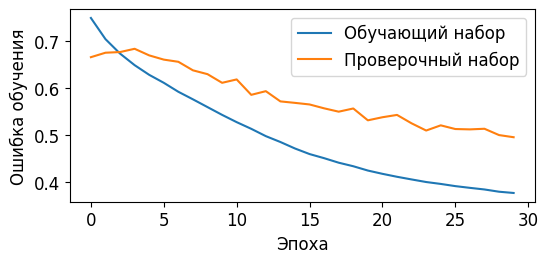

Acc =  0.7018291155098972


Epoch 1: 100%|██████████| 132/132 [00:10<00:00, 12.38it/s]


2023-06-03 17:13:01.267013 Epoch 1, Train loss 0.731, Val loss 0.841, Acc_val = 0.17


Epoch 2: 100%|██████████| 132/132 [00:10<00:00, 12.38it/s]


2023-06-03 17:13:12.184521 Epoch 2, Train loss 0.685, Val loss 0.831, Acc_val = 0.22


Epoch 3: 100%|██████████| 132/132 [00:10<00:00, 12.55it/s]


2023-06-03 17:13:22.955076 Epoch 3, Train loss 0.656, Val loss 0.823, Acc_val = 0.26


Epoch 4: 100%|██████████| 132/132 [00:10<00:00, 12.46it/s]


2023-06-03 17:13:33.810604 Epoch 4, Train loss 0.639, Val loss 0.804, Acc_val = 0.32


Epoch 5: 100%|██████████| 132/132 [00:10<00:00, 12.48it/s]


2023-06-03 17:13:44.648138 Epoch 5, Train loss 0.622, Val loss 0.780, Acc_val = 0.34


Epoch 6: 100%|██████████| 132/132 [00:10<00:00, 12.49it/s]


2023-06-03 17:13:55.473675 Epoch 6, Train loss 0.607, Val loss 0.767, Acc_val = 0.36


Epoch 7: 100%|██████████| 132/132 [00:10<00:00, 12.45it/s]


2023-06-03 17:14:06.334201 Epoch 7, Train loss 0.592, Val loss 0.752, Acc_val = 0.40


Epoch 8: 100%|██████████| 132/132 [00:10<00:00, 12.40it/s]


2023-06-03 17:14:17.235715 Epoch 8, Train loss 0.581, Val loss 0.731, Acc_val = 0.42


Epoch 9: 100%|██████████| 132/132 [00:10<00:00, 12.50it/s]


2023-06-03 17:14:28.057253 Epoch 9, Train loss 0.569, Val loss 0.719, Acc_val = 0.48


Epoch 10: 100%|██████████| 132/132 [00:10<00:00, 12.45it/s]


2023-06-03 17:14:38.915780 Epoch 10, Train loss 0.560, Val loss 0.699, Acc_val = 0.50


Epoch 11: 100%|██████████| 132/132 [00:10<00:00, 12.50it/s]


2023-06-03 17:14:49.740318 Epoch 11, Train loss 0.551, Val loss 0.700, Acc_val = 0.59


Epoch 12: 100%|██████████| 132/132 [00:10<00:00, 12.44it/s]


2023-06-03 17:15:00.624836 Epoch 12, Train loss 0.540, Val loss 0.669, Acc_val = 0.58


Epoch 13: 100%|██████████| 132/132 [00:10<00:00, 12.49it/s]


2023-06-03 17:15:11.450374 Epoch 13, Train loss 0.534, Val loss 0.659, Acc_val = 0.64


Epoch 14: 100%|██████████| 132/132 [00:10<00:00, 12.28it/s]


2023-06-03 17:15:22.455854 Epoch 14, Train loss 0.525, Val loss 0.646, Acc_val = 0.65


Epoch 15: 100%|██████████| 132/132 [00:10<00:00, 12.37it/s]


2023-06-03 17:15:33.379360 Epoch 15, Train loss 0.516, Val loss 0.646, Acc_val = 0.66


Epoch 16: 100%|██████████| 132/132 [00:10<00:00, 12.30it/s]


2023-06-03 17:15:44.368845 Epoch 16, Train loss 0.508, Val loss 0.631, Acc_val = 0.68


Epoch 17: 100%|██████████| 132/132 [00:10<00:00, 12.43it/s]


2023-06-03 17:15:55.253364 Epoch 17, Train loss 0.500, Val loss 0.623, Acc_val = 0.69


Epoch 18: 100%|██████████| 132/132 [00:10<00:00, 12.54it/s]


2023-06-03 17:16:06.046911 Epoch 18, Train loss 0.495, Val loss 0.599, Acc_val = 0.73


Epoch 19: 100%|██████████| 132/132 [00:10<00:00, 12.42it/s]


2023-06-03 17:16:16.935429 Epoch 19, Train loss 0.486, Val loss 0.601, Acc_val = 0.73


Epoch 20: 100%|██████████| 132/132 [00:10<00:00, 12.50it/s]


2023-06-03 17:16:27.754968 Epoch 20, Train loss 0.480, Val loss 0.598, Acc_val = 0.73


Epoch 21: 100%|██████████| 132/132 [00:10<00:00, 12.41it/s]


2023-06-03 17:16:38.647484 Epoch 21, Train loss 0.476, Val loss 0.574, Acc_val = 0.77


Epoch 22: 100%|██████████| 132/132 [00:10<00:00, 12.46it/s]


2023-06-03 17:16:49.501012 Epoch 22, Train loss 0.471, Val loss 0.585, Acc_val = 0.74


Epoch 23: 100%|██████████| 132/132 [00:10<00:00, 12.39it/s]


2023-06-03 17:17:00.429517 Epoch 23, Train loss 0.461, Val loss 0.571, Acc_val = 0.79


Epoch 24: 100%|██████████| 132/132 [00:10<00:00, 12.41it/s]


2023-06-03 17:17:11.376017 Epoch 24, Train loss 0.458, Val loss 0.573, Acc_val = 0.77


Epoch 25: 100%|██████████| 132/132 [00:10<00:00, 12.49it/s]


2023-06-03 17:17:22.201554 Epoch 25, Train loss 0.448, Val loss 0.564, Acc_val = 0.79


Epoch 26: 100%|██████████| 132/132 [00:10<00:00, 12.50it/s]


2023-06-03 17:17:33.019093 Epoch 26, Train loss 0.445, Val loss 0.574, Acc_val = 0.74


Epoch 27: 100%|██████████| 132/132 [00:10<00:00, 12.61it/s]


2023-06-03 17:17:43.738665 Epoch 27, Train loss 0.438, Val loss 0.581, Acc_val = 0.68


Epoch 28: 100%|██████████| 132/132 [00:10<00:00, 12.59it/s]


2023-06-03 17:17:54.474231 Epoch 28, Train loss 0.433, Val loss 0.558, Acc_val = 0.80


Epoch 29: 100%|██████████| 132/132 [00:10<00:00, 12.83it/s]


2023-06-03 17:18:05.024857 Epoch 29, Train loss 0.426, Val loss 0.577, Acc_val = 0.69


Epoch 30: 100%|██████████| 132/132 [00:10<00:00, 12.74it/s]


2023-06-03 17:18:15.647459 Epoch 30, Train loss 0.422, Val loss 0.558, Acc_val = 0.78


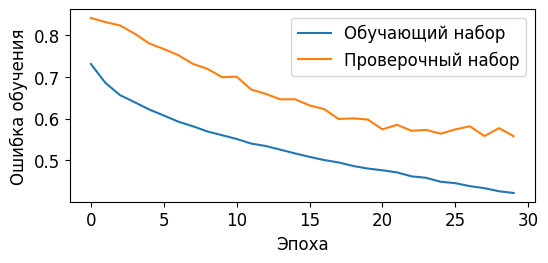

Acc =  0.804537934294493


Epoch 1: 100%|██████████| 127/127 [00:10<00:00, 12.65it/s]


2023-06-03 17:18:36.241872 Epoch 1, Train loss 0.720, Val loss 0.761, Acc_val = 0.40


Epoch 2: 100%|██████████| 127/127 [00:10<00:00, 12.59it/s]


2023-06-03 17:18:46.662539 Epoch 2, Train loss 0.676, Val loss 0.751, Acc_val = 0.42


Epoch 3: 100%|██████████| 127/127 [00:10<00:00, 12.64it/s]


2023-06-03 17:18:57.054215 Epoch 3, Train loss 0.643, Val loss 0.733, Acc_val = 0.47


Epoch 4: 100%|██████████| 127/127 [00:10<00:00, 12.57it/s]


2023-06-03 17:19:07.496875 Epoch 4, Train loss 0.612, Val loss 0.728, Acc_val = 0.53


Epoch 5: 100%|██████████| 127/127 [00:10<00:00, 12.65it/s]


2023-06-03 17:19:17.877555 Epoch 5, Train loss 0.588, Val loss 0.729, Acc_val = 0.57


Epoch 6: 100%|██████████| 127/127 [00:10<00:00, 12.59it/s]


2023-06-03 17:19:28.315216 Epoch 6, Train loss 0.563, Val loss 0.726, Acc_val = 0.61


Epoch 7: 100%|██████████| 127/127 [00:10<00:00, 12.67it/s]


2023-06-03 17:19:38.677902 Epoch 7, Train loss 0.544, Val loss 0.726, Acc_val = 0.64


Epoch 8: 100%|██████████| 127/127 [00:10<00:00, 12.59it/s]


2023-06-03 17:19:49.105566 Epoch 8, Train loss 0.526, Val loss 0.738, Acc_val = 0.66


Epoch 9: 100%|██████████| 127/127 [00:10<00:00, 12.15it/s]


2023-06-03 17:20:00.131040 Epoch 9, Train loss 0.508, Val loss 0.729, Acc_val = 0.66


Epoch 10: 100%|██████████| 127/127 [00:11<00:00, 10.84it/s]


2023-06-03 17:20:12.189183 Epoch 10, Train loss 0.495, Val loss 0.726, Acc_val = 0.66


Epoch 11: 100%|██████████| 127/127 [00:10<00:00, 11.78it/s]


2023-06-03 17:20:23.327620 Epoch 11, Train loss 0.481, Val loss 0.717, Acc_val = 0.66


Epoch 12: 100%|██████████| 127/127 [00:10<00:00, 11.96it/s]


2023-06-03 17:20:34.280117 Epoch 12, Train loss 0.468, Val loss 0.717, Acc_val = 0.67


Epoch 13: 100%|██████████| 127/127 [00:10<00:00, 12.06it/s]


2023-06-03 17:20:45.203623 Epoch 13, Train loss 0.459, Val loss 0.708, Acc_val = 0.67


Epoch 14: 100%|██████████| 127/127 [00:10<00:00, 12.12it/s]


2023-06-03 17:20:56.016165 Epoch 14, Train loss 0.448, Val loss 0.701, Acc_val = 0.67


Epoch 15: 100%|██████████| 127/127 [00:10<00:00, 12.29it/s]


2023-06-03 17:21:06.710745 Epoch 15, Train loss 0.439, Val loss 0.695, Acc_val = 0.68


Epoch 16: 100%|██████████| 127/127 [00:10<00:00, 12.41it/s]


2023-06-03 17:21:17.286362 Epoch 16, Train loss 0.432, Val loss 0.687, Acc_val = 0.68


Epoch 17: 100%|██████████| 127/127 [00:10<00:00, 12.45it/s]


2023-06-03 17:21:27.818993 Epoch 17, Train loss 0.426, Val loss 0.680, Acc_val = 0.69


Epoch 18: 100%|██████████| 127/127 [00:10<00:00, 12.61it/s]


2023-06-03 17:21:38.225665 Epoch 18, Train loss 0.419, Val loss 0.670, Acc_val = 0.68


Epoch 19: 100%|██████████| 127/127 [00:10<00:00, 12.53it/s]


2023-06-03 17:21:48.707312 Epoch 19, Train loss 0.413, Val loss 0.661, Acc_val = 0.69


Epoch 20: 100%|██████████| 127/127 [00:10<00:00, 12.50it/s]


2023-06-03 17:21:59.207954 Epoch 20, Train loss 0.407, Val loss 0.657, Acc_val = 0.69


Epoch 21: 100%|██████████| 127/127 [00:10<00:00, 12.57it/s]


2023-06-03 17:22:09.668607 Epoch 21, Train loss 0.402, Val loss 0.647, Acc_val = 0.69


Epoch 22: 100%|██████████| 127/127 [00:10<00:00, 12.54it/s]


2023-06-03 17:22:20.143258 Epoch 22, Train loss 0.397, Val loss 0.639, Acc_val = 0.68


Epoch 23: 100%|██████████| 127/127 [00:10<00:00, 12.67it/s]


2023-06-03 17:22:30.521938 Epoch 23, Train loss 0.393, Val loss 0.644, Acc_val = 0.73


Epoch 24: 100%|██████████| 127/127 [00:10<00:00, 12.57it/s]


2023-06-03 17:22:40.958600 Epoch 24, Train loss 0.389, Val loss 0.629, Acc_val = 0.70


Epoch 25: 100%|██████████| 127/127 [00:10<00:00, 12.65it/s]


2023-06-03 17:22:51.329282 Epoch 25, Train loss 0.385, Val loss 0.623, Acc_val = 0.72


Epoch 26: 100%|██████████| 127/127 [00:10<00:00, 12.50it/s]


2023-06-03 17:23:01.820927 Epoch 26, Train loss 0.382, Val loss 0.621, Acc_val = 0.73


Epoch 27: 100%|██████████| 127/127 [00:10<00:00, 12.61it/s]


2023-06-03 17:23:12.219601 Epoch 27, Train loss 0.378, Val loss 0.615, Acc_val = 0.74


Epoch 28: 100%|██████████| 127/127 [00:10<00:00, 12.46it/s]


2023-06-03 17:23:22.739236 Epoch 28, Train loss 0.375, Val loss 0.611, Acc_val = 0.74


Epoch 29: 100%|██████████| 127/127 [00:10<00:00, 12.54it/s]


2023-06-03 17:23:33.200890 Epoch 29, Train loss 0.372, Val loss 0.603, Acc_val = 0.74


Epoch 30: 100%|██████████| 127/127 [00:10<00:00, 12.60it/s]


2023-06-03 17:23:43.647548 Epoch 30, Train loss 0.368, Val loss 0.598, Acc_val = 0.74


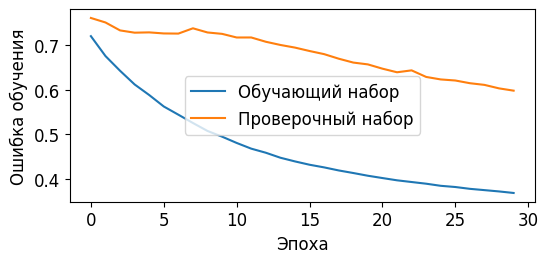

Acc =  0.6862338858195212


Epoch 1: 100%|██████████| 137/137 [00:11<00:00, 11.56it/s]


2023-06-03 17:24:06.096368 Epoch 1, Train loss 0.742, Val loss 0.727, Acc_val = 0.43


Epoch 2: 100%|██████████| 137/137 [00:11<00:00, 12.41it/s]


2023-06-03 17:24:17.432742 Epoch 2, Train loss 0.695, Val loss 0.699, Acc_val = 0.53


Epoch 3: 100%|██████████| 137/137 [00:11<00:00, 12.41it/s]


2023-06-03 17:24:28.765118 Epoch 3, Train loss 0.662, Val loss 0.673, Acc_val = 0.59


Epoch 4: 100%|██████████| 137/137 [00:11<00:00, 12.08it/s]


2023-06-03 17:24:40.408394 Epoch 4, Train loss 0.636, Val loss 0.640, Acc_val = 0.68


Epoch 5: 100%|██████████| 137/137 [00:11<00:00, 11.90it/s]


2023-06-03 17:24:52.236611 Epoch 5, Train loss 0.613, Val loss 0.611, Acc_val = 0.72


Epoch 6: 100%|██████████| 137/137 [00:11<00:00, 12.03it/s]


2023-06-03 17:25:03.904878 Epoch 6, Train loss 0.592, Val loss 0.588, Acc_val = 0.74


Epoch 7: 100%|██████████| 137/137 [00:11<00:00, 12.40it/s]


2023-06-03 17:25:15.242253 Epoch 7, Train loss 0.572, Val loss 0.561, Acc_val = 0.75


Epoch 8: 100%|██████████| 137/137 [00:10<00:00, 12.47it/s]


2023-06-03 17:25:26.519645 Epoch 8, Train loss 0.555, Val loss 0.542, Acc_val = 0.76


Epoch 9: 100%|██████████| 137/137 [00:10<00:00, 12.46it/s]


2023-06-03 17:25:37.802036 Epoch 9, Train loss 0.539, Val loss 0.524, Acc_val = 0.76


Epoch 10: 100%|██████████| 137/137 [00:11<00:00, 12.42it/s]


2023-06-03 17:25:49.136411 Epoch 10, Train loss 0.525, Val loss 0.495, Acc_val = 0.80


Epoch 11: 100%|██████████| 137/137 [00:10<00:00, 12.51it/s]


2023-06-03 17:26:00.376816 Epoch 11, Train loss 0.510, Val loss 0.482, Acc_val = 0.81


Epoch 12: 100%|██████████| 137/137 [00:11<00:00, 12.43it/s]


2023-06-03 17:26:11.693197 Epoch 12, Train loss 0.497, Val loss 0.465, Acc_val = 0.83


Epoch 13: 100%|██████████| 137/137 [00:10<00:00, 12.53it/s]


2023-06-03 17:26:22.914607 Epoch 13, Train loss 0.485, Val loss 0.434, Acc_val = 0.91


Epoch 14: 100%|██████████| 137/137 [00:10<00:00, 12.53it/s]


2023-06-03 17:26:34.135018 Epoch 14, Train loss 0.473, Val loss 0.424, Acc_val = 0.90


Epoch 15: 100%|██████████| 137/137 [00:10<00:00, 12.46it/s]


2023-06-03 17:26:45.418409 Epoch 15, Train loss 0.462, Val loss 0.407, Acc_val = 0.93


Epoch 16: 100%|██████████| 137/137 [00:10<00:00, 12.60it/s]


2023-06-03 17:26:56.571842 Epoch 16, Train loss 0.452, Val loss 0.394, Acc_val = 0.95


Epoch 17: 100%|██████████| 137/137 [00:10<00:00, 12.46it/s]


2023-06-03 17:27:07.872228 Epoch 17, Train loss 0.441, Val loss 0.368, Acc_val = 0.98


Epoch 18: 100%|██████████| 137/137 [00:11<00:00, 12.36it/s]


2023-06-03 17:27:19.239592 Epoch 18, Train loss 0.432, Val loss 0.357, Acc_val = 0.98


Epoch 19: 100%|██████████| 137/137 [00:10<00:00, 12.49it/s]


2023-06-03 17:27:30.496991 Epoch 19, Train loss 0.422, Val loss 0.344, Acc_val = 0.99


Epoch 20: 100%|██████████| 137/137 [00:10<00:00, 12.62it/s]


2023-06-03 17:27:41.662421 Epoch 20, Train loss 0.413, Val loss 0.325, Acc_val = 1.00


Epoch 21: 100%|██████████| 137/137 [00:10<00:00, 12.62it/s]


2023-06-03 17:27:52.805856 Epoch 21, Train loss 0.404, Val loss 0.311, Acc_val = 1.00


Epoch 22: 100%|██████████| 137/137 [00:10<00:00, 12.55it/s]


2023-06-03 17:28:04.004274 Epoch 22, Train loss 0.395, Val loss 0.293, Acc_val = 1.00


Epoch 23: 100%|██████████| 137/137 [00:10<00:00, 12.49it/s]


2023-06-03 17:28:15.345646 Epoch 23, Train loss 0.387, Val loss 0.279, Acc_val = 1.00


Epoch 24: 100%|██████████| 137/137 [00:11<00:00, 12.12it/s]


2023-06-03 17:28:26.932940 Epoch 24, Train loss 0.379, Val loss 0.270, Acc_val = 1.00


Epoch 25: 100%|██████████| 137/137 [00:10<00:00, 12.57it/s]


2023-06-03 17:28:38.120362 Epoch 25, Train loss 0.371, Val loss 0.258, Acc_val = 1.00


Epoch 26: 100%|██████████| 137/137 [00:10<00:00, 12.69it/s]


2023-06-03 17:28:49.199818 Epoch 26, Train loss 0.365, Val loss 0.252, Acc_val = 1.00


Epoch 27: 100%|██████████| 137/137 [00:10<00:00, 12.49it/s]


2023-06-03 17:29:00.441223 Epoch 27, Train loss 0.355, Val loss 0.237, Acc_val = 1.00


Epoch 28: 100%|██████████| 137/137 [00:11<00:00, 12.21it/s]


2023-06-03 17:29:11.959539 Epoch 28, Train loss 0.349, Val loss 0.227, Acc_val = 1.00


Epoch 29: 100%|██████████| 137/137 [00:10<00:00, 12.59it/s]


2023-06-03 17:29:23.125967 Epoch 29, Train loss 0.342, Val loss 0.219, Acc_val = 1.00


Epoch 30: 100%|██████████| 137/137 [00:10<00:00, 12.58it/s]


2023-06-03 17:29:34.306392 Epoch 30, Train loss 0.337, Val loss 0.214, Acc_val = 1.00


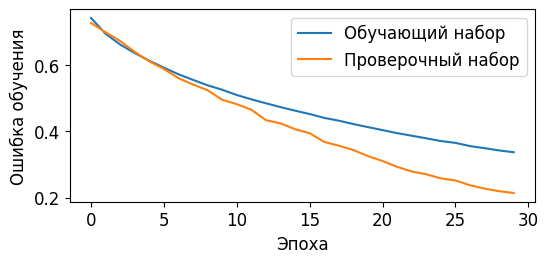

Acc =  0.7415349887133182


Epoch 1: 100%|██████████| 125/125 [00:09<00:00, 12.65it/s]


2023-06-03 17:29:53.201347 Epoch 1, Train loss 0.739, Val loss 0.639, Acc_val = 0.60


Epoch 2: 100%|██████████| 125/125 [00:10<00:00, 12.49it/s]


2023-06-03 17:30:03.685994 Epoch 2, Train loss 0.708, Val loss 0.631, Acc_val = 0.68


Epoch 3: 100%|██████████| 125/125 [00:09<00:00, 12.57it/s]


2023-06-03 17:30:14.119657 Epoch 3, Train loss 0.686, Val loss 0.619, Acc_val = 0.71


Epoch 4: 100%|██████████| 125/125 [00:09<00:00, 12.53it/s]


2023-06-03 17:30:24.575312 Epoch 4, Train loss 0.669, Val loss 0.609, Acc_val = 0.76


Epoch 5: 100%|██████████| 125/125 [00:09<00:00, 12.56it/s]


2023-06-03 17:30:35.010975 Epoch 5, Train loss 0.651, Val loss 0.608, Acc_val = 0.82


Epoch 6: 100%|██████████| 125/125 [00:09<00:00, 12.60it/s]


2023-06-03 17:30:45.399652 Epoch 6, Train loss 0.639, Val loss 0.604, Acc_val = 0.84


Epoch 7: 100%|██████████| 125/125 [00:09<00:00, 12.53it/s]


2023-06-03 17:30:55.842312 Epoch 7, Train loss 0.626, Val loss 0.595, Acc_val = 0.85


Epoch 8: 100%|██████████| 125/125 [00:09<00:00, 12.57it/s]


2023-06-03 17:31:06.256981 Epoch 8, Train loss 0.615, Val loss 0.586, Acc_val = 0.87


Epoch 9: 100%|██████████| 125/125 [00:09<00:00, 12.52it/s]


2023-06-03 17:31:16.716635 Epoch 9, Train loss 0.606, Val loss 0.584, Acc_val = 0.87


Epoch 10: 100%|██████████| 125/125 [00:09<00:00, 12.66it/s]


2023-06-03 17:31:27.063326 Epoch 10, Train loss 0.595, Val loss 0.582, Acc_val = 0.84


Epoch 11: 100%|██████████| 125/125 [00:09<00:00, 12.55it/s]


2023-06-03 17:31:37.491990 Epoch 11, Train loss 0.585, Val loss 0.572, Acc_val = 0.88


Epoch 12: 100%|██████████| 125/125 [00:09<00:00, 12.67it/s]


2023-06-03 17:31:47.831683 Epoch 12, Train loss 0.577, Val loss 0.567, Acc_val = 0.87


Epoch 13: 100%|██████████| 125/125 [00:09<00:00, 12.56it/s]


2023-06-03 17:31:58.260347 Epoch 13, Train loss 0.568, Val loss 0.564, Acc_val = 0.84


Epoch 14: 100%|██████████| 125/125 [00:09<00:00, 12.60it/s]


2023-06-03 17:32:08.655023 Epoch 14, Train loss 0.558, Val loss 0.550, Acc_val = 0.91


Epoch 15: 100%|██████████| 125/125 [00:09<00:00, 12.52it/s]


2023-06-03 17:32:19.126673 Epoch 15, Train loss 0.549, Val loss 0.551, Acc_val = 0.87


Epoch 16: 100%|██████████| 125/125 [00:09<00:00, 12.75it/s]


2023-06-03 17:32:29.408385 Epoch 16, Train loss 0.541, Val loss 0.542, Acc_val = 0.91


Epoch 17: 100%|██████████| 125/125 [00:09<00:00, 12.63it/s]


2023-06-03 17:32:39.777068 Epoch 17, Train loss 0.532, Val loss 0.536, Acc_val = 0.91


Epoch 18: 100%|██████████| 125/125 [00:09<00:00, 12.68it/s]


2023-06-03 17:32:50.099767 Epoch 18, Train loss 0.524, Val loss 0.527, Acc_val = 0.95


Epoch 19: 100%|██████████| 125/125 [00:09<00:00, 12.56it/s]


2023-06-03 17:33:00.523433 Epoch 19, Train loss 0.514, Val loss 0.528, Acc_val = 0.91


Epoch 20: 100%|██████████| 125/125 [00:09<00:00, 12.71it/s]


2023-06-03 17:33:10.828137 Epoch 20, Train loss 0.506, Val loss 0.518, Acc_val = 0.96


Epoch 21: 100%|██████████| 125/125 [00:09<00:00, 12.52it/s]


2023-06-03 17:33:21.281793 Epoch 21, Train loss 0.498, Val loss 0.517, Acc_val = 0.93


Epoch 22: 100%|██████████| 125/125 [00:09<00:00, 12.59it/s]


2023-06-03 17:33:31.674470 Epoch 22, Train loss 0.492, Val loss 0.513, Acc_val = 0.94


Epoch 23: 100%|██████████| 125/125 [00:09<00:00, 12.63it/s]


2023-06-03 17:33:42.044153 Epoch 23, Train loss 0.485, Val loss 0.500, Acc_val = 0.98


Epoch 24: 100%|██████████| 125/125 [00:09<00:00, 12.71it/s]


2023-06-03 17:33:52.364851 Epoch 24, Train loss 0.476, Val loss 0.494, Acc_val = 0.99


Epoch 25: 100%|██████████| 125/125 [00:09<00:00, 12.58it/s]


2023-06-03 17:34:02.764525 Epoch 25, Train loss 0.470, Val loss 0.488, Acc_val = 1.00


Epoch 26: 100%|██████████| 125/125 [00:09<00:00, 12.72it/s]


2023-06-03 17:34:13.068229 Epoch 26, Train loss 0.462, Val loss 0.490, Acc_val = 0.98


Epoch 27: 100%|██████████| 125/125 [00:09<00:00, 12.69it/s]


2023-06-03 17:34:23.391927 Epoch 27, Train loss 0.457, Val loss 0.484, Acc_val = 0.98


Epoch 28: 100%|██████████| 125/125 [00:09<00:00, 12.78it/s]


2023-06-03 17:34:33.640650 Epoch 28, Train loss 0.450, Val loss 0.482, Acc_val = 0.98


Epoch 29: 100%|██████████| 125/125 [00:09<00:00, 12.63it/s]


2023-06-03 17:34:44.018330 Epoch 29, Train loss 0.445, Val loss 0.473, Acc_val = 0.99


Epoch 30: 100%|██████████| 125/125 [00:09<00:00, 12.73it/s]


2023-06-03 17:34:54.367020 Epoch 30, Train loss 0.440, Val loss 0.464, Acc_val = 1.00


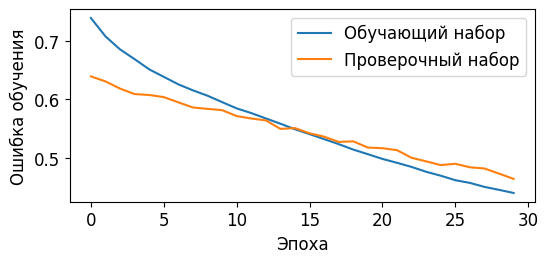

Acc =  0.9345238095238095
Final results
30 epochs. Acc_sk = 0.78 (Sens = 0.80 / Spec = 0.76) 0.70 / 0.80 / 0.69 / 0.74 / 0.93


C:\Users\Tanya\AppData\Local\Temp\ipykernel_13004\1709305254.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(folds),i+1)


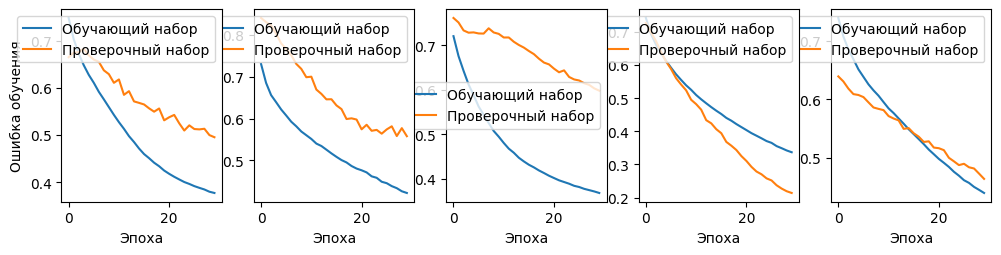

In [52]:
import os
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 40 epochs. Acc_sk = 0.70 (Sens = 0.74 / Spec = 0.66) 0.68 / 0.86 / 0.52 / 0.76 / 0.77
# self.layer1_filt = 2 (before 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.66 (Sens = 0.62 / Spec = 0.70) 0.68 / 0.55 / 0.57 / 0.62 / 0.88
# max_pool_width = 4 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.59 (Sens = 0.53 / Spec = 0.65) 0.65 / 0.50 / 0.56 / 0.61 / 0.63
# self.layer1_filt = 4 + max_pool_width = 4 + lf1_height, lf1_width = 29,43
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.65 (Sens = 0.61 / Spec = 0.69) 0.61 / 0.62 / 0.60 / 0.65 / 0.75 (good behaviour)
# mf2_height,mf2_width = 15,43 (before 15x17)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.70) 0.71 / 0.69 / 0.53 / 0.75 / 0.90
# hf4_height,hf4_width = 15,43 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.76 / Spec = 0.64) 0.73 / 0.66 / 0.53 / 0.73 / 0.86
# hf4_height,hf4_width = 15,31 (before 15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.77 / Spec = 0.64) 0.67 / 0.79 / 0.51 / 0.68 / 0.89
# hf3_height,hf3_width = 13,27 (before 11x11)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.70) 0.78 / 0.86 / 0.53 / 0.74 / 0.89
# mf_height,mf_width = 13,27 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.77 / Spec = 0.75) 0.78 / 0.82 / 0.62 / 0.73 / 0.88
# lf3_height, lf3_width = 13,27 (3x7)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.73) 0.72 / 0.81 / 0.65 / 0.72 / 0.87
# lf3_height, lf3_width = 25,39 (13x27)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.72) 0.65 / 0.67 / 0.62 / 0.74 / 0.92  (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.69 / 0.79 / 0.63 / 0.71 / 0.88
# lf3_height, lf3_width = 5,11
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.72) 0.63 / 0.82 / 0.64 / 0.75 / 0.88
# model with diff input. Now there is 2 input chanells: x and x_diff
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.66 / Spec = 0.76) 0.69 / 0.66 / 0.58 / 0.67 / 0.91
# self.layer1_filt = 6 (before 4)
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.80 / Spec = 0.76) 0.70 / 0.80 / 0.69 / 0.74 / 0.93


k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=30)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
